In [82]:
import numpy as np
#import xgboost as xgb
import pandas as pd
#from xgboost.sklearn import XGBRegressor
#from sklearn import model_selection, metrics
import matplotlib.pyplot as pl
import itertools
import scipy.optimize as so


%matplotlib inline

In [2]:
train = pd.read_csv("train.tsv")
train.drop(["f{}".format(i) for i in range(31, 61)], axis=1, inplace=True)

In [49]:
count = np.zeros([4, 53, 3])

In [50]:
for i in range(len(train[par1])):
    count[train['year'].values[i] - 2012][train['week'].values[i] - 1][train['shift'].values[i] - 1] += 1

In [58]:
unused_indexes = [(i, j, k) for i, year in enumerate(count)
                  for j, week in enumerate(year)
                  for k, shift in enumerate(week)
                  if shift == 0]

In [66]:
len(train[main_features].values)

72457

In [80]:
koefs = np.zeros([4, 53, 3])
indexes = [[[[] for k in range(3)] for j in range(53)] for i in range(4)]
for i in range(len(train['year'])):
    indexes[train['year'].values[i] - 2012][train['week'].values[i] - 1][train['shift'].values[i] - 1].append(i)

In [83]:
for year in range(4):
    for week in range(53):
        for shift in range(3):
            x_val = [i.sum() for i in train[main_features].values[indexes[year][week][shift]]]
            y_val = train['y'].values[indexes[year][week][shift]]
            koefs[year, week, shift] = so.minimize(lambda x: sum(np.abs((x*x_val - y_val))), 2).x

In [67]:
koefs = np.zeros([4, 53, 3, 30])
main_features = ["f{}".format(i) for i in range(1, 31)]
for i in range(4):
    for j in range(53):
        for k in range(3):
            if (i, j, k) not in unused_indexes:
                print i, j, k
                answer = np.array([train['y'].values[ind] for ind in range(len(train['y']))
                                   if train['year'].values[ind] == i + 2012 and
                                   train['week'].values[ind] == j + 1and
                                   train['shift'].values[ind] == k + 1])
                A = np.array([train[main_features].values[ind] for ind in range(len(train['y']))
                              if train['year'].values[ind] == i + 2012 and
                              train['week'].values[ind] == j + 1 and
                              train['shift'].values[ind] == k + 1])
                koefs[i][j][k] = np.dot(np.linalg.inv(np.dot(A.T, A)), np.dot(A.T, answer))

0 51 0
1 0 0
1 0 1
1 1 0
1 1 1
1 1 2
1 2 0
1 2 1
1 2 2
1 3 0
1 3 1
1 3 2
1 4 0
1 4 1
1 4 2
1 5 0
1 5 1
1 5 2
1 6 0
1 6 1
1 6 2
1 7 0
1 7 1
1 7 2
1 8 0
1 8 1
1 8 2
1 9 0
1 9 1
1 9 2
1 10 0
1 10 1
1 10 2
1 11 0
1 11 1
1 11 2
1 12 0
1 12 1
1 12 2
1 13 0
1 13 1
1 13 2
1 14 0
1 14 1
1 14 2
1 15 0
1 15 1
1 15 2
1 16 0
1 16 1
1 16 2
1 17 0
1 17 1
1 17 2
1 18 0
1 18 1
1 18 2
1 19 0
1 19 1
1 19 2
1 20 0
1 20 1
1 20 2
1 21 0
1 21 1
1 21 2
1 22 0
1 22 1
1 22 2
1 23 0
1 23 1
1 23 2
1 24 0
1 24 1
1 24 2
1 25 0
1 25 1
1 25 2
1 26 0
1 26 1
1 26 2
1 27 0
1 27 1
1 27 2
1 28 0
1 28 1
1 28 2
1 29 0
1 29 1
1 29 2
1 30 0
1 30 1
1 30 2
1 31 0
1 31 1
1 31 2
1 32 0
1 32 1
1 32 2
1 33 0
1 33 1
1 33 2
1 34 0
1 34 1
1 34 2
1 35 0
1 35 1
1 35 2
1 36 0
1 36 1
1 36 2
1 37 0
1 37 1
1 37 2
1 38 0
1 38 1
1 38 2
1 39 0
1 39 1
1 39 2
1 40 0
1 40 1
1 40 2
1 41 0
1 41 1
1 41 2
1 42 0
1 42 1
1 42 2
1 43 0
1 43 1
1 43 2
1 44 0
1 44 1
1 44 2
1 45 0
1 45 1
1 45 2
1 46 0
1 46 1
1 46 2
1 47 0
1 47 1
1 47 2
1 48 0
1 48 1
1 48 2


In [33]:
train[["f{}".format(i) for i in range(1, 2)]]

,f1
0,4915.0
1,2230.0
2,5695.0
3,1995.0
4,6515.0
5,445.0
6,445.0
7,1167.0
8,1640.0
9,1440.0


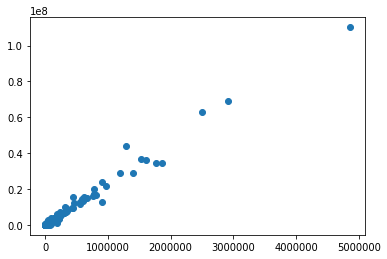

In [42]:
vl1 = 2013
vl2 = 2
vl3 = 4
par1 = 'year'
par2 = 'shift'
par3 = 'week'
indexes = [i for i in range(len(train[par1])) if train[par1][i] == vl1 and
           train[par2][i] == vl2 and
           train[par3][i] == vl3
          ]
summ = [i.sum() for i in train[["f{}".format(i) for i in range(1, 31)]].values[indexes]]
pl.figure()
pl.scatter(train["y"].values[indexes], summ)

In [88]:
koefs

array([[[ 2.        ,  2.        ,  2.        ],
        [ 2.        ,  2.        ,  2.        ],
        [ 2.        ,  2.        ,  2.        ],
        [ 2.        ,  2.        ,  2.        ],
        [ 2.        ,  2.        ,  2.        ],
        [ 2.        ,  2.        ,  2.        ],
        [ 2.        ,  2.        ,  2.        ],
        [ 2.        ,  2.        ,  2.        ],
        [ 2.        ,  2.        ,  2.        ],
        [ 2.        ,  2.        ,  2.        ],
        [ 2.        ,  2.        ,  2.        ],
        [ 2.        ,  2.        ,  2.        ],
        [ 2.        ,  2.        ,  2.        ],
        [ 2.        ,  2.        ,  2.        ],
        [ 2.        ,  2.        ,  2.        ],
        [ 2.        ,  2.        ,  2.        ],
        [ 2.        ,  2.        ,  2.        ],
        [ 2.        ,  2.        ,  2.        ],
        [ 2.        ,  2.        ,  2.        ],
        [ 2.        ,  2.        ,  2.        ],
        [ 2.        

In [85]:
def prediction(X):
    answer = []
    for i in range(len(X['year'])):
        year, week, shift = X[['year', 'week', 'shift']].values[i]
        answer.append(koefs[year - 2012, week - 1, shift - 1]*X[main_features].values[i].sum())
    return answer

In [87]:
pred = prediction(train)

In [89]:
result = 0
for ans, right_ans in zip(pred, np.array(train['y'])):
    result += abs(ans - right_ans) / (abs(right_ans) + abs(ans))
    
print result * 200 / len(pred)

32.2951424264


In [70]:
test = pd.read_csv("test.tsv")
sample_submission = pd.read_csv("sample_submission.tsv")
sample_submission['y'] = prediction(test)
sample_submission.to_csv("submission2.tsv", sep=',', index=False)

In [35]:
for i in range(1, 31):
    for j_1, j_2 in zip(train['f{}'.format(i)], train['f{}'.format(i + 30)]):
        if j_1 != j_2:
            print("different!")

In [73]:
def SMAPE(regressor, X, y):
    prediction = regressor.predict(X)
    result = 0
    for ans, right_ans in zip(prediction, np.array(y)):
        result += abs(ans - right_ans) / (abs(right_ans) + abs(ans))
    return result * 200 / len(y)
    
def test_regressor(regressor, data, target, features):
    tscv = model_selection.TimeSeriesSplit(n_splits=5)
    score = []
    for train_index, test_index in tscv.split(data):
        X_train, X_test = data[features].values[train_index], data[features].values[test_index]
        y_train, y_test = data[target].values[train_index], data[target].values[test_index]
        regressor.fit(X_train, y_train, eval_metric='mae')
        score.append(SMAPE(regressor, X_test, y_test))

    return np.array(score).mean()
"""
def print_params(params_arr, names_arr, params):
    for i, p, name in zip(range(len(params)), params, names_arr):
        if len(params_arr[i]) > 1:
            if isinstance(p, int):
                print "{} = {}".format(name, p), end="  "
            else:
                print("{} = {:.4f}".format(name, p), end="  ")  

def get_best_params(params_arr, names_arr, train, target, features):
    maximum = 200
    best_params = []
    for params in itertools.product(*params_arr):
        d = {}
        for i, name in enumerate(names_arr):
            d[name] = params[i]
        print_params(params_arr, names_arr, params)
        result = test_regressor(XGBRegressor(**d), train, target, features)
        print("SMPAE = {:.4f}".format(result))
        if (result < maximum):
            maximum = result
            best_params = params
    print("best parametrs:")
    print_params(params_arr, names_arr, best_params)
"""

'\ndef print_params(params_arr, names_arr, params):\n    for i, p, name in zip(range(len(params)), params, names_arr):\n        if len(params_arr[i]) > 1:\n            if isinstance(p, int):\n                print "{} = {}".format(name, p), end="  "\n            else:\n                print("{} = {:.4f}".format(name, p), end="  ")  \n\ndef get_best_params(params_arr, names_arr, train, target, features):\n    maximum = 200\n    best_params = []\n    for params in itertools.product(*params_arr):\n        d = {}\n        for i, name in enumerate(names_arr):\n            d[name] = params[i]\n        print_params(params_arr, names_arr, params)\n        result = test_regressor(XGBRegressor(**d), train, target, features)\n        print("SMPAE = {:.4f}".format(result))\n        if (result < maximum):\n            maximum = result\n            best_params = params\n    print("best parametrs:")\n    print_params(params_arr, names_arr, best_params)\n'

In [191]:
target = ['y']
features = [x for x in train.columns if x not in [target, 'item_id', 'year', 'weak', 'shift']]
param_names = ['learning_rate',
               'n_estimators',
               'max_depth',
               'min_child_weight',
               'gamma',
               'subsample',
               'colsample_bytree',
               'nthread',
               'seed',
              ]

In [195]:
params_1 = [[0.1], range(100, 110, 2), [5], [1], [0], [0.8], [0.8], [4], [27]]

In [199]:
get_best_params(params_1, param_names, train, target, features)

n_estimators = 100  SMPAE = 18.9412
n_estimators = 102  SMPAE = 18.8868
n_estimators = 104  SMPAE = 18.9182
n_estimators = 106  SMPAE = 18.9693
n_estimators = 108  SMPAE = 19.0434
best parametrs:
n_estimators = 102  

In [202]:
params_2 = [[0.1], [102], range(3, 10), range(1, 6), [0], [0.8], [0.8], [4], [27]]
get_best_params(params_2, param_names, train, target, features)

max_depth = 3  min_child_weight = 1  SMPAE = 28.2304
max_depth = 3  min_child_weight = 2  SMPAE = 29.1355
max_depth = 3  min_child_weight = 3  SMPAE = 30.1970
max_depth = 3  min_child_weight = 4  SMPAE = 30.4533
max_depth = 3  min_child_weight = 5  SMPAE = 30.2757
max_depth = 4  min_child_weight = 1  SMPAE = 22.3518
max_depth = 4  min_child_weight = 2  SMPAE = 23.2648
max_depth = 4  min_child_weight = 3  SMPAE = 24.9585
max_depth = 4  min_child_weight = 4  SMPAE = 25.4751
max_depth = 4  min_child_weight = 5  SMPAE = 25.6518
max_depth = 5  min_child_weight = 1  SMPAE = 18.8868
max_depth = 5  min_child_weight = 2  SMPAE = 19.1192
max_depth = 5  min_child_weight = 3  SMPAE = 19.7433
max_depth = 5  min_child_weight = 4  SMPAE = 19.6694
max_depth = 5  min_child_weight = 5  SMPAE = 25.0435
max_depth = 6  min_child_weight = 1  SMPAE = 18.5929
max_depth = 6  min_child_weight = 2  SMPAE = 20.7352
max_depth = 6  min_child_weight = 3  SMPAE = 21.5878
max_depth = 6  min_child_weight = 4  SMPAE = 2

In [205]:
params_3 = [[0.1], [102], [9], [1], np.linspace(0, 0.3, 15), [0.8], [0.8], [4], [27]]
get_best_params(params_3, param_names, train, target, features)

gamma = 0.0000  SMPAE = 9.2712
gamma = 0.0214  SMPAE = 9.2712
gamma = 0.0429  SMPAE = 9.2712
gamma = 0.0643  SMPAE = 9.2712
gamma = 0.0857  SMPAE = 9.2712
gamma = 0.1071  SMPAE = 9.2712
gamma = 0.1286  SMPAE = 9.2712
gamma = 0.1500  SMPAE = 9.2712
gamma = 0.1714  SMPAE = 9.2712
gamma = 0.1929  SMPAE = 9.2712
gamma = 0.2143  SMPAE = 9.2712
gamma = 0.2357  SMPAE = 9.2712
gamma = 0.2571  SMPAE = 9.2712
gamma = 0.2786  SMPAE = 9.2712
gamma = 0.3000  SMPAE = 9.2712
best parametrs:
gamma = 0.0000  

In [ ]:
params_4 = [[0.1], [102], [9], [1], [0], np.linspace(0.6, 0.9, 5),
            np.linspace(0.6, 0.9, 5), [4], [27]]
get_best_params(params_4, param_names, train, target, features)